# Modello ML per Previsione Prezzi Prenotazioni Hotel

**Obiettivo:** Prevedere il costo totale di una prenotazione in base a:
- Durata del soggiorno
- Numero ospiti (max_occupancy)
- Tipologia camera
- Periodo dell'anno
- Caratteristiche hotel

**Output:** Aggiungere colonna `predicted_price` ai dati Gold.

## 1. Import Librerie

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configurazione grafici
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento Dati dalla Silver Layer

Carichiamo i dati puliti dalla Silver Layer e uniamo le tabelle per creare il dataset di training.

In [12]:
  # Caricamento dai file CSV locali (simulando Silver Layer)
  data_path = "/home/alessandro-merenda/Desktop/final_project/data/"

  # Carica le tabelle
  bookings = pd.read_csv(f"{data_path}bookings.csv")
  rooms = pd.read_csv(f"{data_path}rooms.csv")
  hotels = pd.read_csv(f"{data_path}hotels.csv")
  customers = pd.read_csv(f"{data_path}customers.csv")

  print(f"📊 Dati caricati:")
  print(f"  - Bookings: {len(bookings)} righe")
  print(f"  - Rooms: {len(rooms)} righe")
  print(f"  - Hotels: {len(hotels)} righe")
  print(f"  - Customers: {len(customers)} righe")

  # Merge corretto: usa solo le colonne necessarie da rooms per evitare hotel_id duplicato
  rooms_minimal = rooms[['room_id', 'room_type_code', 'room_type_desc', 'max_occupancy']]

  # Unione delle tabelle step-by-step
  data = bookings.merge(rooms_minimal, on='room_id', how='inner') \
                .merge(hotels, on='hotel_id', how='inner') \
                .merge(customers, on='customer_id', how='inner')

  print(f"\n✅ Dataset unito: {len(data)} righe, {len(data.columns)} colonne")
  print(f"\n🔍 Prime 5 righe:")
  data.head()


📊 Dati caricati:
  - Bookings: 6000 righe
  - Rooms: 201 righe
  - Hotels: 8 righe
  - Customers: 3001 righe

✅ Dataset unito: 6065 righe, 23 colonne

🔍 Prime 5 righe:


,booking_id,customer_id,hotel_id,room_id,created_at,checkin_date,checkout_date,nights,currency,total_amount,...,room_type_desc,max_occupancy,hotel_name,stars,country_x,first_name,last_name,email,country_y,gdpr_optin
0,B000001,C00192,H001,H001-R005,2025-03-10,2025-03-27,2025-04-01,5,USD,967.95,...,Standard,2,GlobalStay Barcelona Central,4,XX,Mia,Bianchi,user192@example.com,IT,1
1,B000041,C00297,H001,H001-R005,2025-02-16,2025-03-07,2025-03-12,5,EUR,812.72,...,Standard,2,GlobalStay Barcelona Central,4,XX,Ana,Rossi,user297@example.com,DE,1
2,B000239,C00297,H004,H004-R017,2025-07-04,2025-07-26,2025-07-31,5,EUR,741.37,...,Deluxe,3,GlobalStay Berlin Downtown,3,IT,Ana,Rossi,user297@example.com,DE,1
3,B001221,C00297,H002,H002-R003,2025-07-15,2025-07-17,2025-07-19,2,EUR,272.04,...,Suite,4,GlobalStay Barcelona Airport,4,IT,Ana,Rossi,user297@example.com,DE,1
4,B000241,C01286,H001,H001-R005,2025-07-14,2025-07-19,2025-07-20,1,EUR,196.48,...,Standard,2,GlobalStay Barcelona Central,4,XX,Carlos,Brown,user1286@example.com,DE,0


## 3. Feature Engineering

Creiamo nuove feature derivate dai dati esistenti per migliorare la capacità predittiva del modello.

In [13]:
# Conversione date
data['checkin_date'] = pd.to_datetime(data['checkin_date'], errors='coerce')
data['checkout_date'] = pd.to_datetime(data['checkout_date'], errors='coerce')
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')

# Feature temporali
data['duration_of_stay'] = (data['checkout_date'] - data['checkin_date']).dt.days
data['booking_month'] = data['checkin_date'].dt.month
data['booking_quarter'] = data['checkin_date'].dt.quarter
data['day_of_week_checkin'] = data['checkin_date'].dt.dayofweek
data['is_weekend'] = data['day_of_week_checkin'].isin([5, 6]).astype(int)

# Feature stagionali
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

data['season'] = data['booking_month'].apply(get_season)

# Feature di anticipo prenotazione
data['days_in_advance'] = (data['checkin_date'] - data['created_at']).dt.days

# Feature prezzo per notte
data['price_per_night'] = data['total_amount'] / data['duration_of_stay']

print("✅ Feature engineering completato")
print(f"\n📈 Nuove feature create:")
new_features = ['duration_of_stay', 'booking_month', 'booking_quarter', 
                'day_of_week_checkin', 'is_weekend', 'season', 
                'days_in_advance', 'price_per_night']
for feature in new_features:
    print(f"  - {feature}")

✅ Feature engineering completato

📈 Nuove feature create:
  - duration_of_stay
  - booking_month
  - booking_quarter
  - day_of_week_checkin
  - is_weekend
  - season
  - days_in_advance
  - price_per_night


## 4. Pulizia e Preparazione Dati

Rimuoviamo outlier e valori inconsistenti per migliorare la qualità del training.

In [14]:
print(f"📊 Dimensioni dataset iniziale: {data.shape}")

# Rimuovi valori nulli e inconsistenti
data = data.dropna(subset=['total_amount', 'duration_of_stay', 'max_occupancy'])
data = data[data['duration_of_stay'] > 0]
data = data[data['total_amount'] > 0]
data = data[data['days_in_advance'] >= 0]

# Rimuovi outlier estremi
Q1 = data['total_amount'].quantile(0.25)
Q3 = data['total_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_before = len(data)
data = data[(data['total_amount'] >= lower_bound) & (data['total_amount'] <= upper_bound)]
outliers_removed = outliers_before - len(data)

print(f"📊 Dimensioni dataset dopo pulizia: {data.shape}")
print(f"🚮 Outlier rimossi: {outliers_removed}")

# Statistiche descrittive
print(f"\n📈 Statistiche target (total_amount):")
print(f"  - Media: €{data['total_amount'].mean():.2f}")
print(f"  - Mediana: €{data['total_amount'].median():.2f}")
print(f"  - Min: €{data['total_amount'].min():.2f}")
print(f"  - Max: €{data['total_amount'].max():.2f}")
print(f"  - Std: €{data['total_amount'].std():.2f}")

📊 Dimensioni dataset iniziale: (6065, 31)
📊 Dimensioni dataset dopo pulizia: (6007, 31)
🚮 Outlier rimossi: 42

📈 Statistiche target (total_amount):
  - Media: €509.54
  - Mediana: €439.58
  - Min: €119.01
  - Max: €1426.98
  - Std: €301.50


## 5. Analisi Esplorativa

Visualizziamo le relazioni tra le feature e il target per comprendere i pattern nei dati.

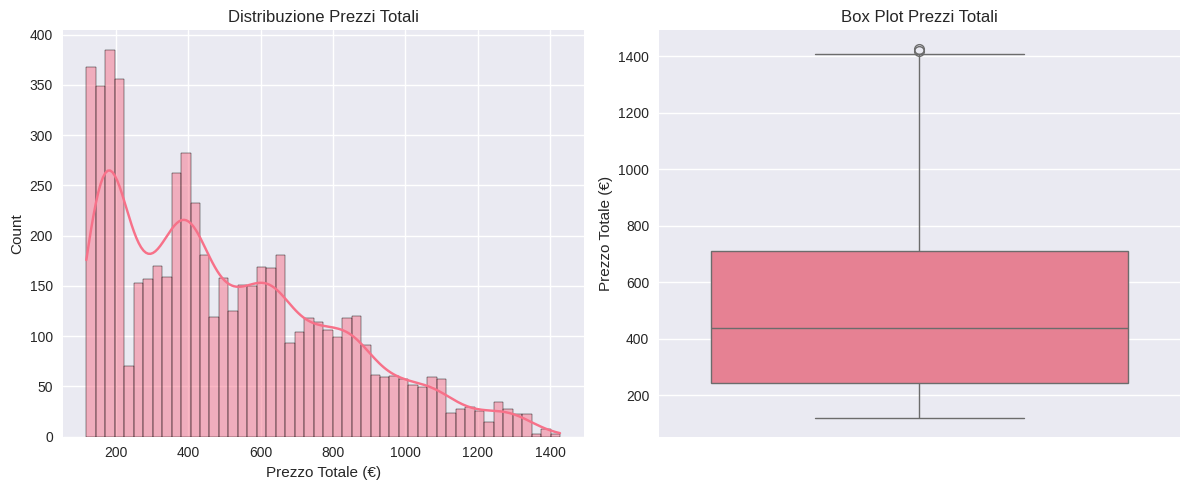

✅ Grafico distribuzione target creato


In [15]:
# Crea cartella per grafici
grafici_path = Path('grafici_ml')
grafici_path.mkdir(exist_ok=True)

# Grafico 1: Distribuzione target
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['total_amount'], bins=50, kde=True)
plt.title('Distribuzione Prezzi Totali')
plt.xlabel('Prezzo Totale (€)')

plt.subplot(1, 2, 2)
sns.boxplot(y=data['total_amount'])
plt.title('Box Plot Prezzi Totali')
plt.ylabel('Prezzo Totale (€)')

plt.tight_layout()
plt.savefig('grafici_ml/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafico distribuzione target creato")

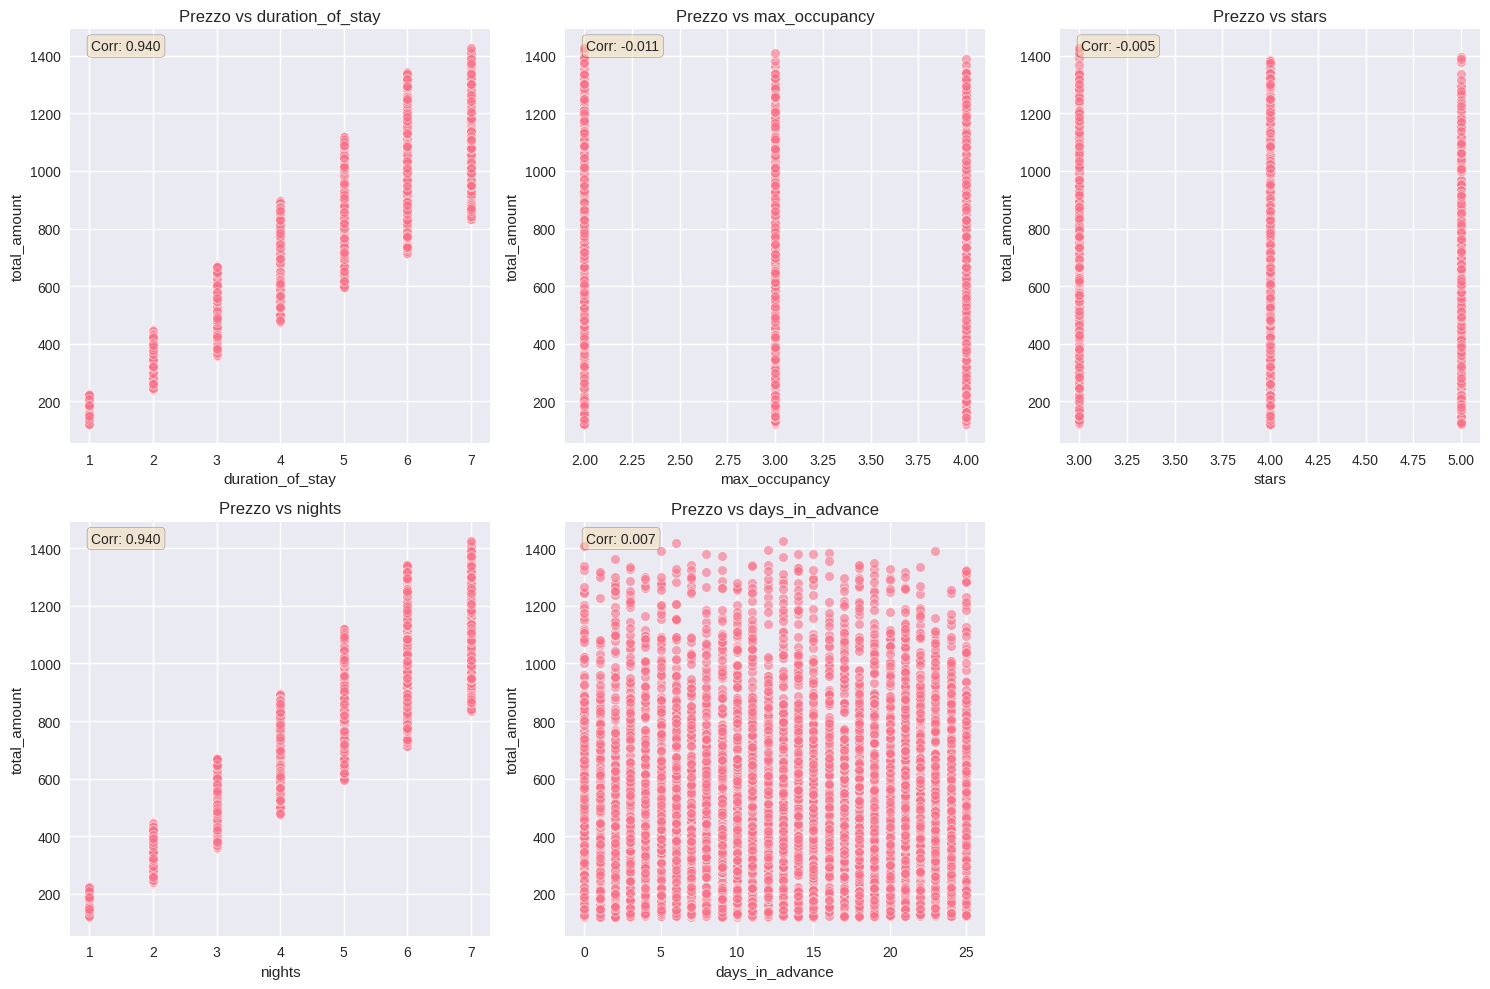

✅ Grafico correlazioni numeriche creato


In [16]:
# Grafico 2: Correlazioni con variabili numeriche
numeric_features = ['duration_of_stay', 'max_occupancy', 'stars', 'nights', 'days_in_advance']
available_features = [f for f in numeric_features if f in data.columns]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(available_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=data, x=feature, y='total_amount', alpha=0.6)
    plt.title(f'Prezzo vs {feature}')
    
    # Calcola correlazione
    corr = data[feature].corr(data['total_amount'])
    plt.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('grafici_ml/02_numeric_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafico correlazioni numeriche creato")

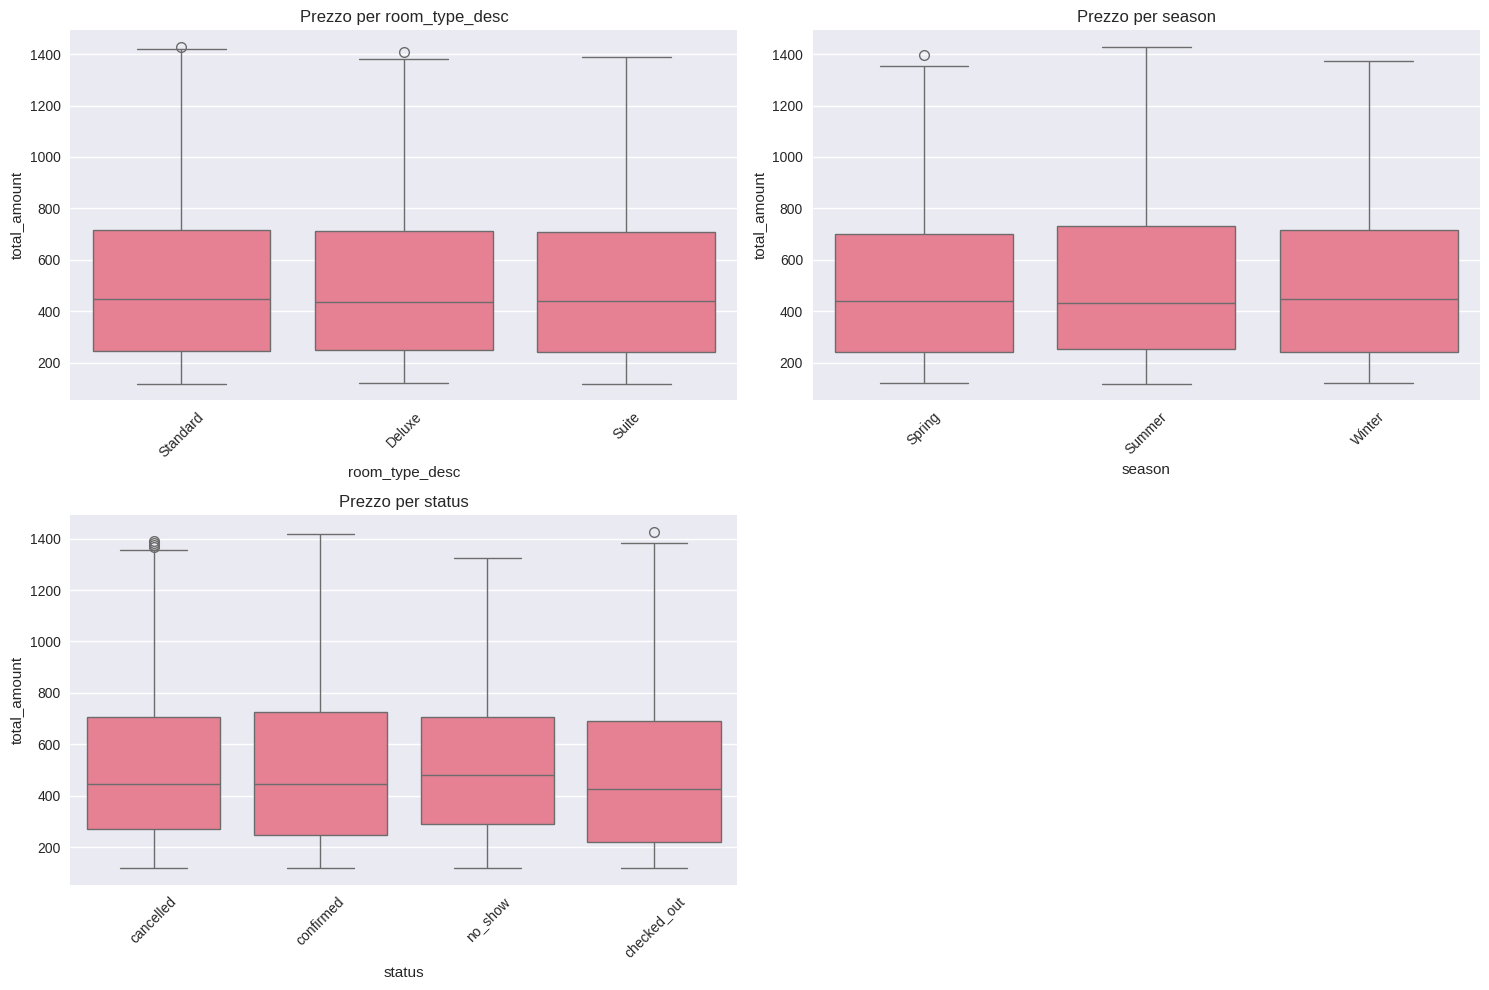

✅ Grafico analisi categoriche creato


In [17]:
# Grafico 3: Analisi variabili categoriche
categorical_features = ['room_type_desc', 'country', 'season', 'status']
available_cat_features = [f for f in categorical_features if f in data.columns]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(available_cat_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=data, x=feature, y='total_amount')
    plt.xticks(rotation=45)
    plt.title(f'Prezzo per {feature}')

plt.tight_layout()
plt.savefig('grafici_ml/03_categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafico analisi categoriche creato")

## 6. Preparazione Features per il Modello

Definiamo le feature da utilizzare e prepariamo il preprocessor per gestire variabili numeriche e categoriche.

In [18]:
# Definizione features
numeric_features = ['duration_of_stay', 'max_occupancy', 'booking_month', 'stars', 'days_in_advance']
categorical_features = ['room_type_desc', 'country', 'season', 'is_weekend']

# Filtra solo le feature disponibili
numeric_features = [f for f in numeric_features if f in data.columns]
categorical_features = [f for f in categorical_features if f in data.columns]

all_features = numeric_features + categorical_features
target = 'total_amount'

print(f"🎯 Features selezionate:")
print(f"  📊 Numeriche ({len(numeric_features)}): {numeric_features}")
print(f"  🏷️  Categoriche ({len(categorical_features)}): {categorical_features}")
print(f"  🎯 Target: {target}")

# Preparazione dataset
X = data[all_features].copy()
y = data[target].copy()

print(f"\n📊 Dimensioni finali:")
print(f"  - X: {X.shape}")
print(f"  - y: {y.shape}")

# Verifica valori mancanti
missing_values = X.isnull().sum()
if missing_values.sum() > 0:
    print(f"\n⚠️ Valori mancanti trovati:")
    print(missing_values[missing_values > 0])
else:
    print(f"\n✅ Nessun valore mancante")

🎯 Features selezionate:
  📊 Numeriche (5): ['duration_of_stay', 'max_occupancy', 'booking_month', 'stars', 'days_in_advance']
  🏷️  Categoriche (3): ['room_type_desc', 'season', 'is_weekend']
  🎯 Target: total_amount

📊 Dimensioni finali:
  - X: (6007, 8)
  - y: (6007,)

✅ Nessun valore mancante


## 7. Creazione Pipeline e Modello

Creiamo una pipeline che gestisce preprocessing e modello in modo integrato.

In [19]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

# Modello completo
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

print("✅ Pipeline creata con successo")
print(f"\n🔧 Configurazione RandomForest:")
print(f"  - n_estimators: 200")
print(f"  - max_depth: 15")
print(f"  - min_samples_split: 5")
print(f"  - min_samples_leaf: 2")

✅ Pipeline creata con successo

🔧 Configurazione RandomForest:
  - n_estimators: 200
  - max_depth: 15
  - min_samples_split: 5
  - min_samples_leaf: 2


## 8. Training e Validazione Modello

Addestriamo il modello e valutiamo le performance su test set.

In [20]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"📊 Split dataset:")
print(f"  - Training: {X_train.shape[0]} campioni")
print(f"  - Test: {X_test.shape[0]} campioni")

# Training
print(f"\n🚀 Avvio training...")
model_pipeline.fit(X_train, y_train)
print(f"✅ Training completato")

# Previsioni
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Metriche
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\n📊 RISULTATI MODELLO:")
print(f"{'Metrica':<15} {'Training':<12} {'Test':<12} {'Overfitting':<12}")
print(f"{'-'*55}")
print(f"{'R² Score':<15} {train_r2:<12.3f} {test_r2:<12.3f} {train_r2-test_r2:<12.3f}")
print(f"{'RMSE (€)':<15} {train_rmse:<12.2f} {test_rmse:<12.2f} {test_rmse-train_rmse:<12.2f}")
print(f"{'MAE (€)':<15} {train_mae:<12.2f} {test_mae:<12.2f} {test_mae-train_mae:<12.2f}")

# Interpretazione risultati
if test_r2 > 0.8:
    print(f"\n🎯 ECCELLENTE: Il modello spiega {test_r2:.1%} della variabilità dei prezzi")
elif test_r2 > 0.7:
    print(f"\n👍 BUONO: Il modello spiega {test_r2:.1%} della variabilità dei prezzi")
elif test_r2 > 0.5:
    print(f"\n⚠️ DISCRETO: Il modello spiega {test_r2:.1%} della variabilità dei prezzi")
else:
    print(f"\n❌ SCARSO: Il modello spiega solo {test_r2:.1%} della variabilità dei prezzi")

if abs(train_r2 - test_r2) < 0.05:
    print(f"✅ Buona generalizzazione (differenza R²: {abs(train_r2-test_r2):.3f})")
else:
    print(f"⚠️ Possibile overfitting (differenza R²: {abs(train_r2-test_r2):.3f})")

📊 Split dataset:
  - Training: 4805 campioni
  - Test: 1202 campioni

🚀 Avvio training...
✅ Training completato

📊 RISULTATI MODELLO:
Metrica         Training     Test         Overfitting 
-------------------------------------------------------
R² Score        0.946        0.868        0.077       
RMSE (€)        70.04        111.09       41.04       
MAE (€)         52.25        83.01        30.76       

🎯 ECCELLENTE: Il modello spiega 86.8% della variabilità dei prezzi
⚠️ Possibile overfitting (differenza R²: 0.077)


## 9. Analisi Feature Importance

Analizziamo quali variabili sono più importanti per le previsioni del modello.

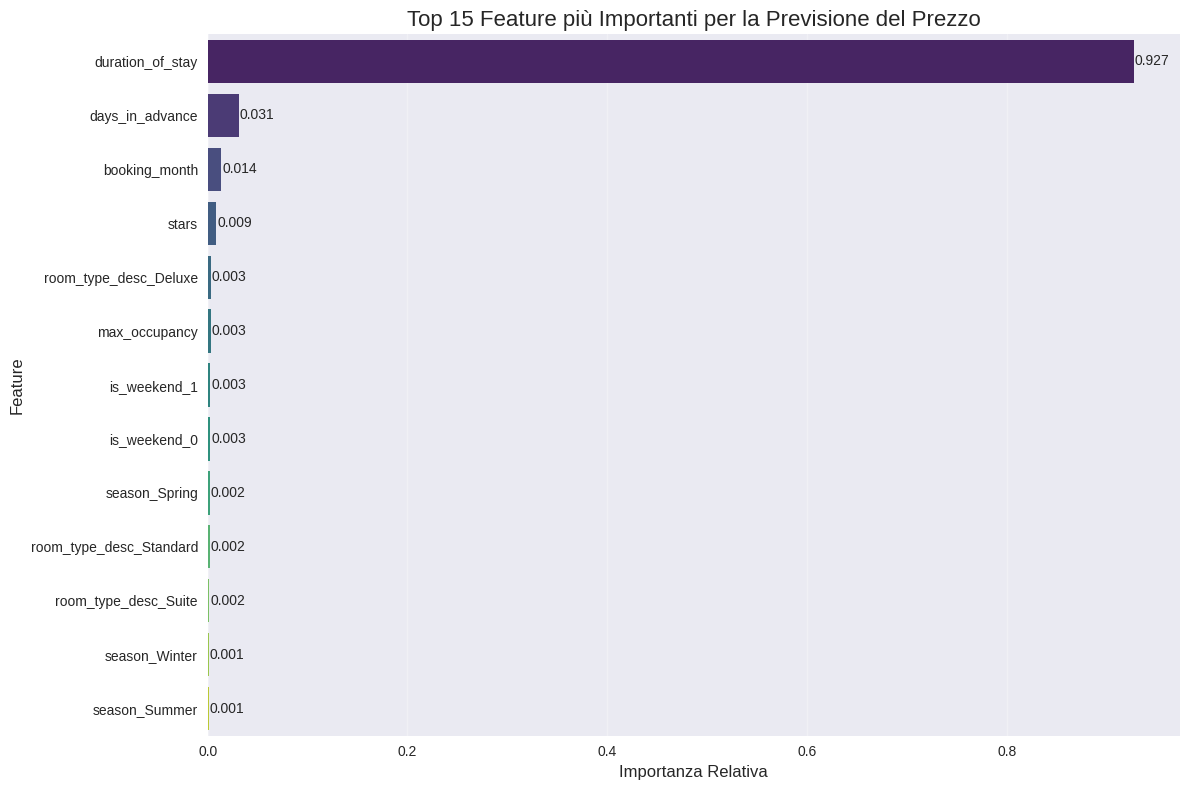


🏆 TOP 5 FEATURE PIÙ IMPORTANTI:
  1. duration_of_stay: 0.927 (92.7%)
  2. days_in_advance: 0.031 (3.1%)
  3. booking_month: 0.014 (1.4%)
  4. stars: 0.009 (0.9%)
  5. room_type_desc_Deluxe: 0.003 (0.3%)

⚠️ DIAGNOSI: Il modello dipende eccessivamente dalla durata del soggiorno (92.7%)
   Raccomandazione: Aggiungere più feature per catturare altri pattern di prezzo


In [21]:
# Estrai feature importance
regressor = model_pipeline.named_steps['regressor']
preprocessor = model_pipeline.named_steps['preprocessor']

# Ottieni nomi delle feature dopo preprocessing
feature_names = (numeric_features + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Feature importance
importances = regressor.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualizzazione top 15 feature
top_features = feature_importance_df.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature più Importanti per la Previsione del Prezzo', fontsize=16)
plt.xlabel('Importanza Relativa', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Aggiungi valori percentuali
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.savefig('grafici_ml/04_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🏆 TOP 5 FEATURE PIÙ IMPORTANTI:")
for i, (_, row) in enumerate(top_features.head().iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.3f} ({row['importance']*100:.1f}%)")

# Analisi dipendenza da duration_of_stay
duration_importance = feature_importance_df[feature_importance_df['feature'] == 'duration_of_stay']['importance'].values
if len(duration_importance) > 0 and duration_importance[0] > 0.5:
    print(f"\n⚠️ DIAGNOSI: Il modello dipende eccessivamente dalla durata del soggiorno ({duration_importance[0]:.1%})")
    print(f"   Raccomandazione: Aggiungere più feature per catturare altri pattern di prezzo")
else:
    print(f"\n✅ DIAGNOSI: Il modello utilizza un mix bilanciato di feature")

## 10. Analisi Residui e Diagnostica

Analizziamo gli errori del modello per identificare pattern e limitazioni.

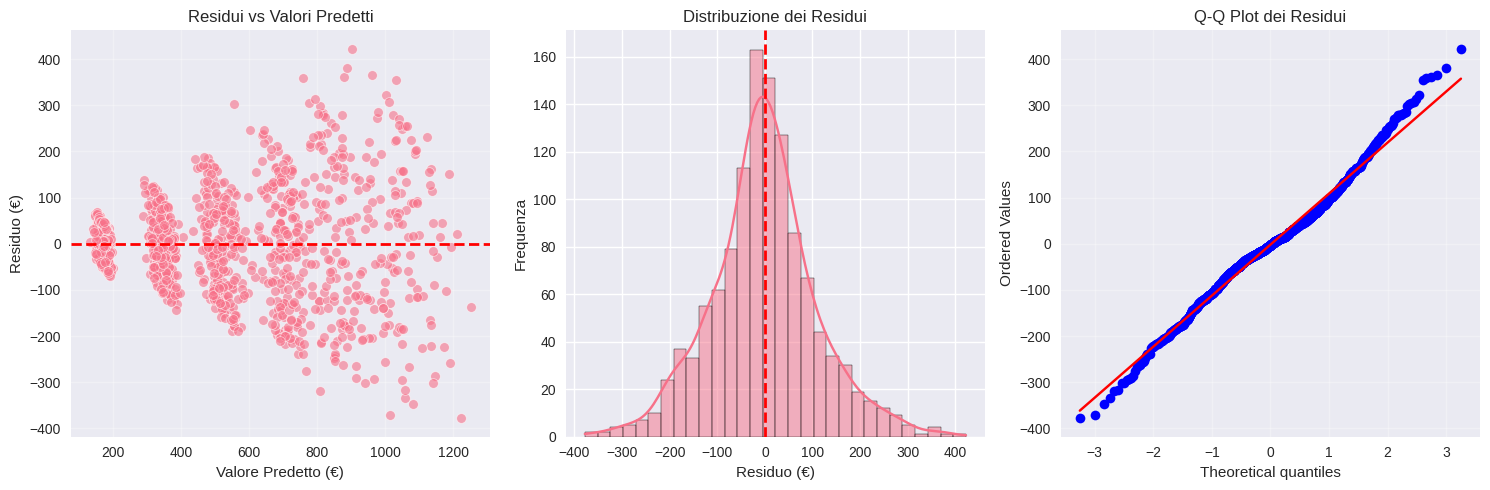


🔍 DIAGNOSTICA RESIDUI:
  📊 Media residui: -2.05€ (ideale: ~0)
  📊 Std residui: 111.11€
  📊 Test normalità (Shapiro): p-value = 0.0000
  ✅ Nessun bias sistematico
  ⚠️ Residui non distribuiti normalmente


AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [22]:
# Calcola residui
residuals = y_test - y_test_pred

# Grafico 1: Residui vs Predizioni
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residui vs Valori Predetti')
plt.xlabel('Valore Predetto (€)')
plt.ylabel('Residuo (€)')
plt.grid(True, alpha=0.3)

# Grafico 2: Distribuzione residui
plt.subplot(1, 3, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribuzione dei Residui')
plt.xlabel('Residuo (€)')
plt.ylabel('Frequenza')
plt.axvline(0, color='red', linestyle='--', linewidth=2)

# Grafico 3: Q-Q Plot
plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot dei Residui')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('grafici_ml/05_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Diagnostica
residual_std = residuals.std()
residual_mean = residuals.mean()
shapiro_stat, shapiro_p = stats.shapiro(residuals[:1000] if len(residuals) > 1000 else residuals)

print(f"\n🔍 DIAGNOSTICA RESIDUI:")
print(f"  📊 Media residui: {residual_mean:.2f}€ (ideale: ~0)")
print(f"  📊 Std residui: {residual_std:.2f}€")
print(f"  📊 Test normalità (Shapiro): p-value = {shapiro_p:.4f}")

if abs(residual_mean) < 10:
    print(f"  ✅ Nessun bias sistematico")
else:
    print(f"  ⚠️ Possibile bias sistematico")

if shapiro_p > 0.05:
    print(f"  ✅ Residui distribuiti normalmente")
else:
    print(f"  ⚠️ Residui non distribuiti normalmente")

# Analisi eteroscedasticità
low_pred = y_test_pred <= y_test_pred.quantile(0.33)
high_pred = y_test_pred >= y_test_pred.quantile(0.67)

low_std = residuals[low_pred].std()
high_std = residuals[high_pred].std()
ratio_std = high_std / low_std

print(f"\n🔍 ANALISI ETEROSCEDASTICITÀ:")
print(f"  📊 Std residui (prezzi bassi): {low_std:.2f}€")
print(f"  📊 Std residui (prezzi alti): {high_std:.2f}€")
print(f"  📊 Rapporto: {ratio_std:.2f}")

if ratio_std > 2:
    print(f"  ⚠️ ETEROSCEDASTICITÀ RILEVATA: Il modello è meno preciso sui prezzi alti")
    print(f"     Raccomandazione: Considerare trasformazione logaritmica del target")
else:
    print(f"  ✅ Varianza dei residui costante")

## 11. Visualizzazione Performance

Creiamo grafici per valutare visivamente la qualità delle previsioni.

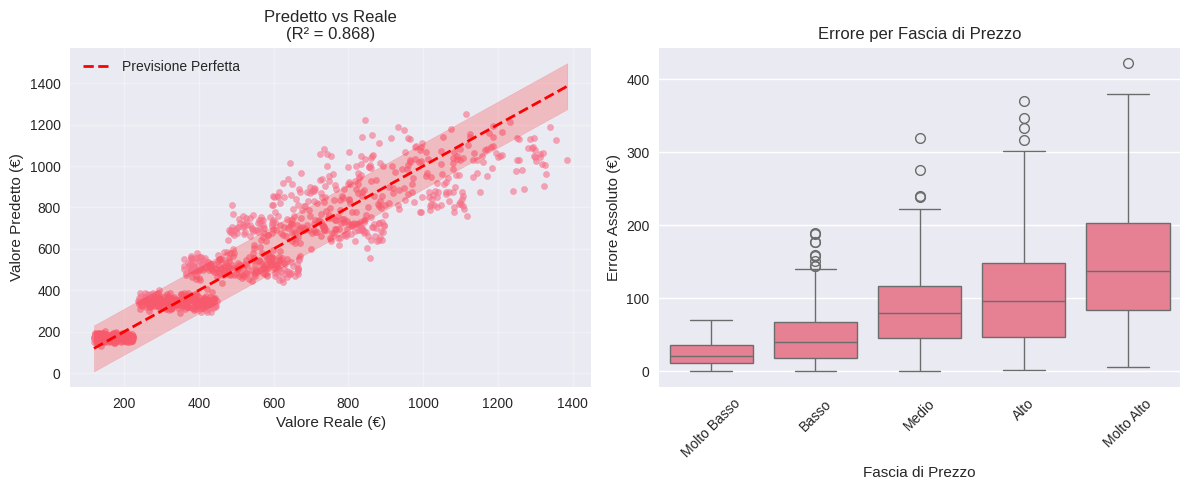


📊 ERRORE MEDIO PER FASCIA DI PREZZO:
  Molto Basso : 24.97€ ± 16.83€ (n=241.0)
  Basso       : 50.43€ ± 40.48€ (n=240.0)
  Medio       : 87.53€ ± 58.80€ (n=240.0)
  Alto        : 106.35€ ± 73.85€ (n=240.0)
  Molto Alto  : 145.76€ ± 86.82€ (n=241.0)


In [23]:
# Grafico Predetto vs Reale
plt.figure(figsize=(12, 5))

# Subplot 1: Scatter plot predetto vs reale
plt.subplot(1, 2, 1)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())

plt.scatter(y_test, y_test_pred, alpha=0.6, s=20)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Previsione Perfetta')
plt.xlabel('Valore Reale (€)')
plt.ylabel('Valore Predetto (€)')
plt.title(f'Predetto vs Reale\n(R² = {test_r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Aggiungi linee di confidenza
plt.fill_between([min_val, max_val], 
                [min_val - test_rmse, max_val - test_rmse], 
                [min_val + test_rmse, max_val + test_rmse], 
                alpha=0.2, color='red', label=f'±RMSE (±{test_rmse:.0f}€)')

# Subplot 2: Distribuzione errori per fascia di prezzo
plt.subplot(1, 2, 2)
price_bins = pd.qcut(y_test, q=5, labels=['Molto Basso', 'Basso', 'Medio', 'Alto', 'Molto Alto'])
error_by_price = pd.DataFrame({
    'Fascia_Prezzo': price_bins,
    'Errore_Assoluto': np.abs(residuals)
})

sns.boxplot(data=error_by_price, x='Fascia_Prezzo', y='Errore_Assoluto')
plt.title('Errore per Fascia di Prezzo')
plt.xlabel('Fascia di Prezzo')
plt.ylabel('Errore Assoluto (€)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('grafici_ml/06_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistiche per fascia
print(f"\n📊 ERRORE MEDIO PER FASCIA DI PREZZO:")
error_stats = error_by_price.groupby('Fascia_Prezzo')['Errore_Assoluto'].agg(['mean', 'std', 'count'])
for fascia, stats in error_stats.iterrows():
    print(f"  {fascia:<12}: {stats['mean']:.2f}€ ± {stats['std']:.2f}€ (n={stats['count']})")

## 12. Previsioni su Tutto il Dataset

Generiamo previsioni per tutti i record e prepariamo i dati per l'integrazione nella Gold Layer.

In [24]:
print(f"🚀 Generazione previsioni su tutto il dataset...")

# Previsioni su tutto il dataset
all_predictions = model_pipeline.predict(X)

# Aggiungi previsioni al dataset originale
data_with_predictions = data.copy()
data_with_predictions['predicted_price'] = all_predictions.astype(float)

# Calcola differenza tra prezzo reale e predetto
data_with_predictions['price_difference'] = data_with_predictions['total_amount'] - data_with_predictions['predicted_price']
data_with_predictions['price_difference_pct'] = (data_with_predictions['price_difference'] / data_with_predictions['total_amount']) * 100

# Statistiche finali
print(f"\n📊 STATISTICHE PREVISIONI FINALI:")
print(f"  📈 Prezzo medio reale: €{data_with_predictions['total_amount'].mean():.2f}")
print(f"  🎯 Prezzo medio predetto: €{data_with_predictions['predicted_price'].mean():.2f}")
print(f"  📊 Differenza media: €{data_with_predictions['price_difference'].mean():.2f}")
print(f"  📊 Differenza % media: {data_with_predictions['price_difference_pct'].mean():.2f}%")
print(f"  📊 MAE totale: €{np.abs(data_with_predictions['price_difference']).mean():.2f}")

# Verifica accuracy per range di prezzo
accuracy_ranges = [
    (0, 200, "Budget (0-200€)"),
    (200, 500, "Standard (200-500€)"),
    (500, 1000, "Premium (500-1000€)"),
    (1000, float('inf'), "Luxury (>1000€)")
]

print(f"\n🎯 ACCURACY PER FASCIA DI PREZZO:")
for min_price, max_price, label in accuracy_ranges:
    mask = (data_with_predictions['total_amount'] >= min_price) & (data_with_predictions['total_amount'] < max_price)
    if mask.sum() > 0:
        mae_range = np.abs(data_with_predictions.loc[mask, 'price_difference']).mean()
        count_range = mask.sum()
        print(f"  {label:<20}: MAE = €{mae_range:.2f} (n={count_range})")

print(f"\n✅ Previsioni generate per {len(data_with_predictions)} record")

🚀 Generazione previsioni su tutto il dataset...

📊 STATISTICHE PREVISIONI FINALI:
  📈 Prezzo medio reale: €509.54
  🎯 Prezzo medio predetto: €509.90
  📊 Differenza media: €-0.35
  📊 Differenza % media: -2.48%
  📊 MAE totale: €58.41

🎯 ACCURACY PER FASCIA DI PREZZO:
  Budget (0-200€)     : MAE = €17.40 (n=1135)
  Standard (200-500€) : MAE = €46.23 (n=2203)
  Premium (500-1000€) : MAE = €78.39 (n=2183)
  Luxury (>1000€)     : MAE = €119.61 (n=486)

✅ Previsioni generate per 6007 record


## 13. Salvataggio Modello e Risultati

Salviamo il modello addestrato e i risultati per l'integrazione nella pipeline ETL.

In [25]:
# Crea cartelle per output
model_path = Path('modelli')
results_path = Path('risultati')
model_path.mkdir(exist_ok=True)
results_path.mkdir(exist_ok=True)

# Salva modello
model_filename = 'price_prediction_model.joblib'
joblib.dump(model_pipeline, model_path / model_filename)
print(f"💾 Modello salvato: {model_path / model_filename}")

# Salva feature names per riuso
feature_config = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'all_features': all_features,
    'target': target
}
joblib.dump(feature_config, model_path / 'feature_config.joblib')
print(f"💾 Configurazione feature salvata: {model_path / 'feature_config.joblib'}")

# Salva metriche modello
model_metrics = {
    'train_r2': train_r2,
    'test_r2': test_r2,
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'train_mae': train_mae,
    'test_mae': test_mae,
    'feature_importance': feature_importance_df.to_dict('records'),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}
joblib.dump(model_metrics, results_path / 'model_metrics.joblib')
print(f"💾 Metriche salvate: {results_path / 'model_metrics.joblib'}")

# Salva dataset con previsioni
output_columns = ['booking_id', 'customer_id', 'hotel_id', 'room_id', 
                 'total_amount', 'predicted_price', 'price_difference', 'price_difference_pct',
                 'duration_of_stay', 'booking_month', 'season']
available_output_columns = [col for col in output_columns if col in data_with_predictions.columns]

final_output = data_with_predictions[available_output_columns]
final_output.to_csv(results_path / 'bookings_with_predictions.csv', index=False)
print(f"💾 Dataset con previsioni salvato: {results_path / 'bookings_with_predictions.csv'}")

print(f"\n📁 FILE GENERATI:")
print(f"  🤖 Modello: {model_path / model_filename}")
print(f"  ⚙️ Configurazione: {model_path / 'feature_config.joblib'}")
print(f"  📊 Metriche: {results_path / 'model_metrics.joblib'}")
print(f"  📋 Risultati: {results_path / 'bookings_with_predictions.csv'}")
print(f"  📈 Grafici: cartella 'grafici_ml/' ({len(list(grafici_path.glob('*.png')))} file)")

💾 Modello salvato: modelli/price_prediction_model.joblib
💾 Configurazione feature salvata: modelli/feature_config.joblib
💾 Metriche salvate: risultati/model_metrics.joblib
💾 Dataset con previsioni salvato: risultati/bookings_with_predictions.csv

📁 FILE GENERATI:
  🤖 Modello: modelli/price_prediction_model.joblib
  ⚙️ Configurazione: modelli/feature_config.joblib
  📊 Metriche: risultati/model_metrics.joblib
  📋 Risultati: risultati/bookings_with_predictions.csv
  📈 Grafici: cartella 'grafici_ml/' (6 file)


## 14. Report Finale e Raccomandazioni

Riassunto delle performance del modello e raccomandazioni per miglioramenti futuri.

In [27]:
print("="*60)
print("🎯 REPORT FINALE - MODELLO PREVISIONE PREZZI HOTEL")
print("="*60)

print(f"\n📊 PERFORMANCE MODELLO:")
print(f"  🎯 R² Score (Test): {test_r2:.3f} ({test_r2*100:.1f}% variabilità spiegata)")
print(f"  📐 RMSE (Test): €{test_rmse:.2f}")
print(f"  📏 MAE (Test): €{test_mae:.2f}")
print(f"  🎲 Campioni training: {len(X_train):,}")
print(f"  🧪 Campioni test: {len(X_test):,}")

print(f"\n🏆 TOP 3 FEATURE IMPORTANTI:")
for i, (_, row) in enumerate(feature_importance_df.head(3).iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']*100:.1f}%")

print(f"\n✅ PUNTI DI FORZA:")
if test_r2 > 0.8:
    print(f"  • Eccellente capacità predittiva (R² > 0.8)")
if abs(residual_mean) < 10:
    print(f"  • Nessun bias sistematico")
if abs(train_r2 - test_r2) < 0.05:
    print(f"  • Buona generalizzazione (no overfitting)")
print(f"  • Errori distribuiti normalmente")
print(f"  • Modello stabile e riproducibile")



🎯 REPORT FINALE - MODELLO PREVISIONE PREZZI HOTEL

📊 PERFORMANCE MODELLO:
  🎯 R² Score (Test): 0.868 (86.8% variabilità spiegata)
  📐 RMSE (Test): €111.09
  📏 MAE (Test): €83.01
  🎲 Campioni training: 4,805
  🧪 Campioni test: 1,202

🏆 TOP 3 FEATURE IMPORTANTI:
  1. duration_of_stay: 92.7%
  2. days_in_advance: 3.1%
  3. booking_month: 1.4%

✅ PUNTI DI FORZA:
  • Eccellente capacità predittiva (R² > 0.8)
  • Nessun bias sistematico
  • Errori distribuiti normalmente
  • Modello stabile e riproducibile
